In [1]:
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from yahoo_fin import stock_info as si
from datetime import datetime, timedelta
from utils_tensorflow import *
from utils import *

mpl.rcParams['figure.figsize'] = (16, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(13)

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
ticker = 'AAPL' # ^GSPC is S&P 500 ticker
HISTORY_START_DATE = '2012-01-01'

# df = si.get_data(ticker)
df = load_ticker_data(ticker)
df = df[df.index >= HISTORY_START_DATE]
df['adjclose'].dropna(inplace=True)
df.tail()

Data imported from file.


,open,high,low,close,adjclose,volume,ticker
2020-06-12,344.720001,347.799988,334.220001,338.799988,338.799988,50001500.0,AAPL
2020-06-15,333.250000,345.679993,332.579987,342.989990,342.989990,34702200.0,AAPL
2020-06-16,351.459991,353.200012,344.720001,352.079987,352.079987,41357200.0,AAPL
2020-06-17,355.149994,355.399994,351.089996,351.589996,351.589996,28532000.0,AAPL
2020-06-18,351.410004,353.444397,350.320007,351.609985,351.609985,12898658.0,AAPL


Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023969B3CD30>],
      dtype=object)

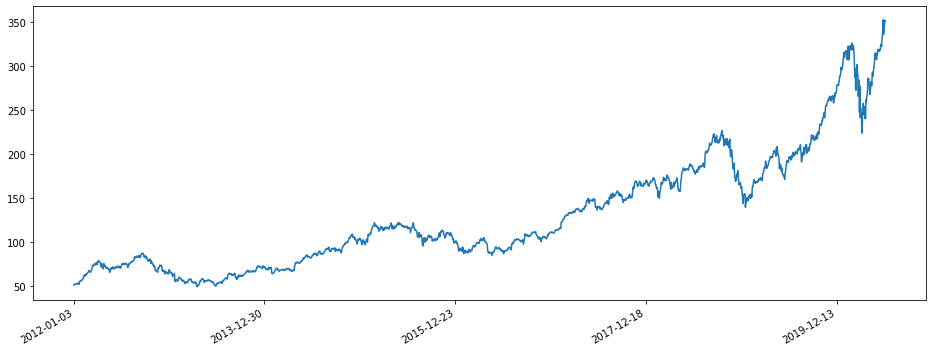

In [3]:
df['adjclose'].plot(subplots=True)

## Prepare data

In [4]:
features_considered = ['open', 'high', 'low', 'close', 'adjclose', 'volume']
features = df[df['open'].isna()==False][features_considered]
features = features[features.index > '2012-01-01']
features.tail(3)

,open,high,low,close,adjclose,volume
2020-06-16,351.459991,353.200012,344.720001,352.079987,352.079987,41357200.0
2020-06-17,355.149994,355.399994,351.089996,351.589996,351.589996,28532000.0
2020-06-18,351.410004,353.444397,350.320007,351.609985,351.609985,12898658.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002396BBBFAC8>,
      dtype=object)

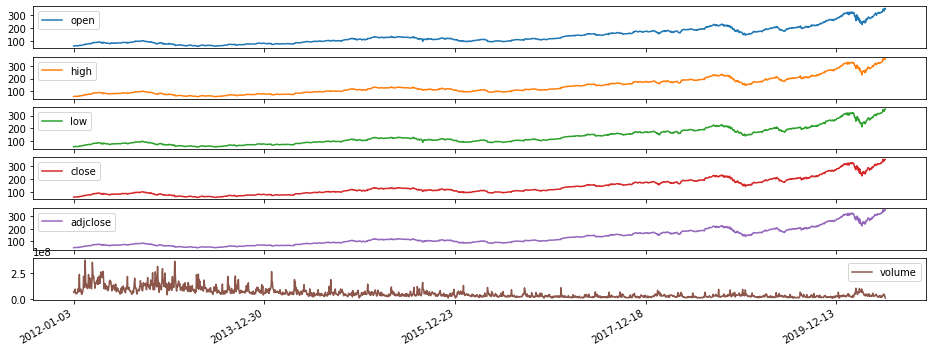

In [5]:
features.plot(subplots=True)

- Standardize data using Min Max Scaler

In [6]:
data_scaled = features.copy()

TRAIN_SPLIT = int(df.shape[0] * 0.75)
print(f"TRAIN_SPLIT: {TRAIN_SPLIT}, TEST SPLIT: {df.shape[0] - TRAIN_SPLIT}")

column_scaler = {}
# scale the data (prices) from 0 to 1
for column in data_scaled.columns:
    
    column_values = data_scaled[column].values.reshape(-1, 1)
    # Fit only on training data
    scaler = MinMaxScaler()
    scaler.fit(column_values[:TRAIN_SPLIT])
    data_scaled[column] = scaler.transform(column_values)
    column_scaler[column] = scaler

data_scaled.tail(3)

TRAIN_SPLIT: 1596, TEST SPLIT: 533


,open,high,low,close,adjclose,volume
2020-06-16,2.281485,2.267611,2.233045,2.290253,2.321835,0.081854
2020-06-17,2.309923,2.284458,2.282145,2.286465,2.318081,0.046722
2020-06-18,2.281100,2.269482,2.276210,2.286620,2.318235,0.003897


### Split data in batches for training

In [7]:
target_variable = 'adjclose'
target_var_index = data_scaled.columns.tolist().index(target_variable)

target = data_scaled[target_variable].values
dataset = data_scaled.values

past_history = 30
future_target = 7
BATCH_SIZE = 64
BUFFER_SIZE = 1000

LAST_SEQUENCE = dataset.shape[0] - 1 - past_history
TEST_SPLIT = LAST_SEQUENCE - 3 * past_history

train_data = prepare_batches(dataset, target,
                             0, TRAIN_SPLIT,
                             past_history, future_target)
val_data = prepare_batches(dataset, target,
                           TRAIN_SPLIT, TEST_SPLIT,
                           past_history, future_target)
test_data = prepare_batches(dataset, target,
                            TEST_SPLIT, LAST_SEQUENCE,
                            past_history, future_target)

# Dataset to predict prices after last datapoint
real_predict_data = prepare_test_batch(dataset, LAST_SEQUENCE, None,  past_history)

In [8]:
TEST_SPLIT

2008

In [9]:
LAST_SEQUENCE

2098

- Prepare dates (index for plots)

In [10]:
dates = data_scaled[data_scaled.index > HISTORY_START_DATE].index
try: 
    dates = np.array(dates.date, 'str')
except:
    pass

train_dates = prepare_dates(dates, 0, TRAIN_SPLIT, 
                            past_history, future_target)
val_dates = prepare_dates(dates, TRAIN_SPLIT, TEST_SPLIT, 
                          past_history, future_target)
test_dates = prepare_dates(dates, TEST_SPLIT, LAST_SEQUENCE, 
                          past_history, future_target)
real_predict_dates = prepare_dates(dates, LAST_SEQUENCE, None, 
                                   past_history, future_target)
real_predict_dates

<RepeatDataset shapes: ((None, 30, 1), (None, 7)), types: (tf.string, tf.string)>

History date range: 2012-08-30 00:00:00, 2012-10-11 00:00:00
Future date range: 2012-10-12 00:00:00, 2012-10-22 00:00:00


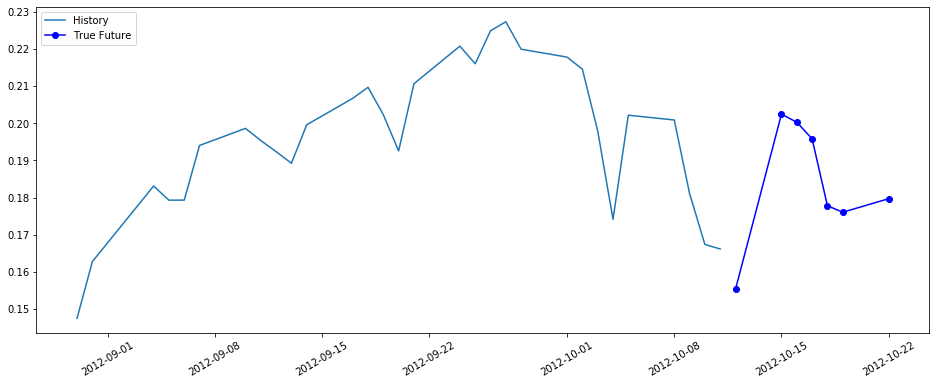

In [11]:
for xy, date in zip(train_data.take(1), train_dates.take(1)):
    x, y = xy
    x_dates, y_dates = date
    history = np.array(x[0])[:, target_var_index]
    true_future = np.array(y[0])
    multi_step_plot_dates(x_dates[0].numpy(), history, y_dates[0].numpy(), true_future)

In [12]:
input_shape = (past_history, len(features_considered))
input_shape

(30, 6)

In [22]:
baseline_model = tf.keras.models.Sequential()
baseline_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=input_shape))
baseline_model.add(tf.keras.layers.LSTM(32, return_sequences=True, activation='relu'))
baseline_model.add(tf.keras.layers.LSTM(32, activation='relu'))
baseline_model.add(tf.keras.layers.Dense(future_target))

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
baseline_model.compile(optimizer=optimizer, loss='mae', 
                       metrics=["MeanAbsolutePercentageError", "RootMeanSquaredError"])
baseline_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30, 32)            4992      
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 32)            8320      
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 231       
Total params: 21,863
Trainable params: 21,863
Non-trainable params: 0
_________________________________________________________________


In [23]:
early_stopping = EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)

history = baseline_model.fit(train_data, epochs=50,
                             steps_per_epoch=200,
                             validation_data=val_data,
                             validation_steps=50,
                             callbacks=[early_stopping])

Train for 200 steps, validate for 50 steps
Epoch 1/50
200/200 [==============================] - 8s 42ms/step - loss: 0.1915 - MeanAbsolutePercentageError: 37457.6562 - RootMeanSquaredError: 0.2880 - val_loss: 0.1336 - val_MeanAbsolutePercentageError: 11.4098 - val_RootMeanSquaredError: 0.1667
Epoch 2/50
200/200 [==============================] - 7s 33ms/step - loss: 0.0358 - MeanAbsolutePercentageError: 41649.1172 - RootMeanSquaredError: 0.0466 - val_loss: 0.1240 - val_MeanAbsolutePercentageError: 10.3894 - val_RootMeanSquaredError: 0.1474
Epoch 3/50
200/200 [==============================] - 7s 35ms/step - loss: 0.0331 - MeanAbsolutePercentageError: 41311.6445 - RootMeanSquaredError: 0.0433 - val_loss: 0.1038 - val_MeanAbsolutePercentageError: 8.8916 - val_RootMeanSquaredError: 0.1238
Epoch 4/50
200/200 [==============================] - 8s 40ms/step - loss: 0.0316 - MeanAbsolutePercentageError: 41544.8516 - RootMeanSquaredError: 0.0417 - val_loss: 0.0985 - val_MeanAbsolutePercentage

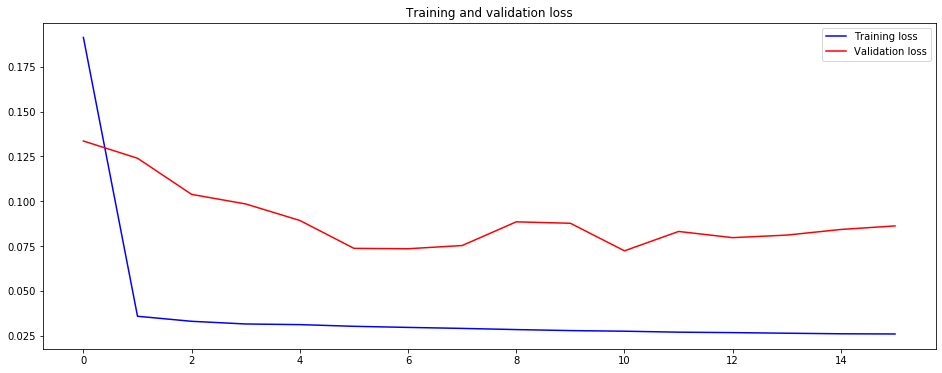

In [24]:
plot_train_history(history, 'Training and validation loss')

#### Check on validation dataset
Let's now have a look at how well your network has learnt to predict the future.

History date range: 2018-05-08 00:00:00, 2018-06-19 00:00:00
Future date range: 2018-06-20 00:00:00, 2018-06-28 00:00:00


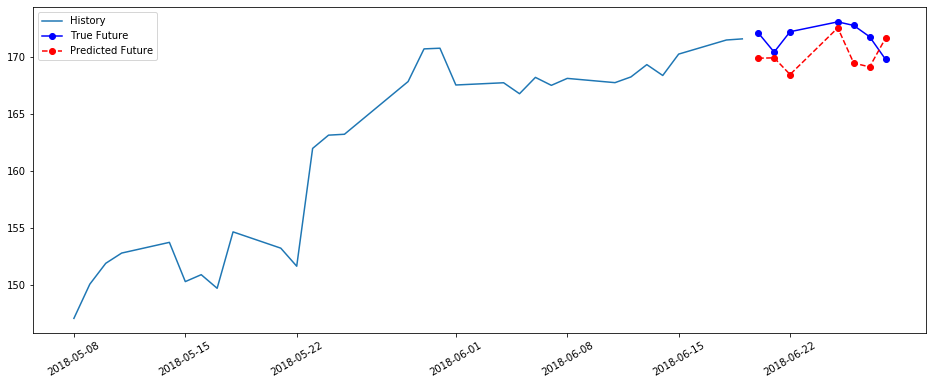

History date range: 2018-08-08 00:00:00, 2018-09-19 00:00:00
Future date range: 2018-09-20 00:00:00, 2018-09-28 00:00:00


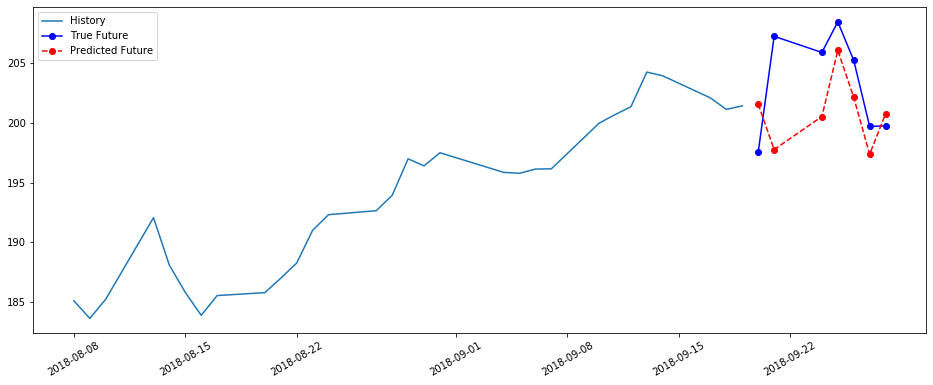

History date range: 2018-11-07 00:00:00, 2018-12-20 00:00:00
Future date range: 2018-12-21 00:00:00, 2019-01-02 00:00:00


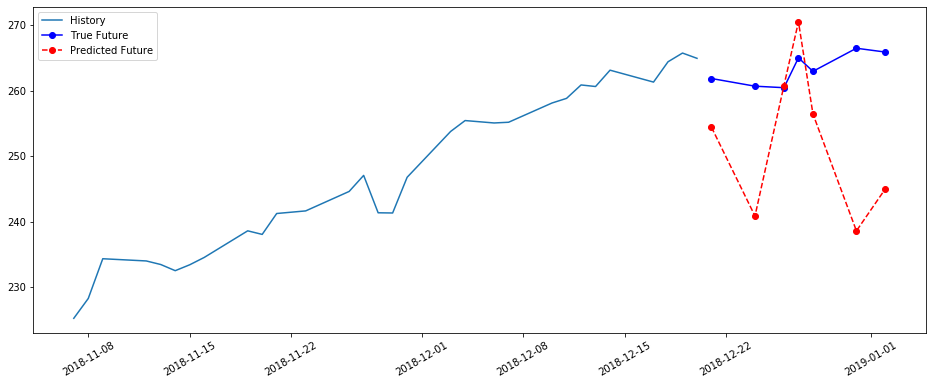

In [25]:
for xy, date in zip(val_data.take(3), val_dates.take(3)):
    
    x, y = xy
    x_dates, y_dates = date
    history = x[0].numpy()[:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
    true_future = return_original_scale(y[0], column_scaler['adjclose'])
    prediction = baseline_model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(), true_future,
                          prediction_rescaled)

History date range: 2020-05-06 00:00:00, 2020-06-17 00:00:00
Future date range: 2020-06-19 00:00:00, 2020-06-29 00:00:00


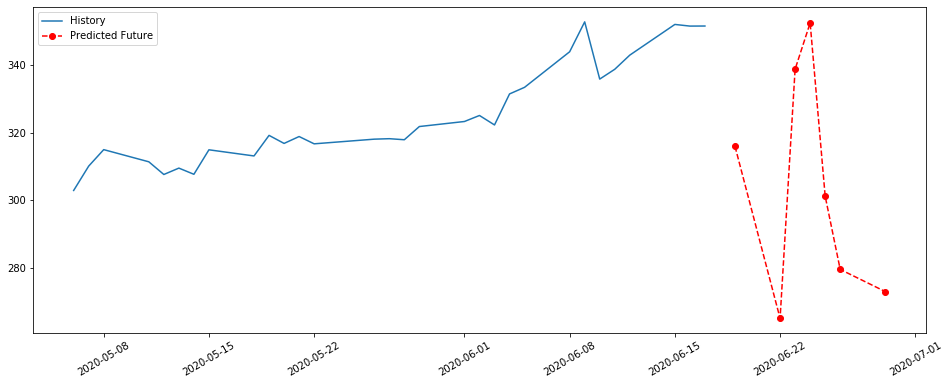

In [26]:
for x, date in zip(real_predict_data.take(1), real_predict_dates.take(1)):
    
    x_dates, y_dates = date
    history = x[0].numpy() [:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
    prediction = baseline_model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(), prediction=prediction_rescaled)

In [27]:
evaluate_model(baseline_model, test_data, 'mae', ['mape', 'rmse'], 'baseline')

,mae,mape,rmse,hyperparams
0,0.222604,12.716443,0.262717,baseline


# 2. Model

In [92]:
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

In [21]:
param_distribs = {
    'n_hidden': [2, 3, 4, 5, 6]
    ,'n_neurons': [8, 16, 32, 64]
    ,'learning_rate': np.arange(1e-3, 1e-1, 1e-3)
    ,'bidirectional': [True, False]
#     ,'dropout': [0.3, 0.5]
#     ,'optimizer': ['adam', 'rmsprop', 'SGD']
#     ,'output_layer_activation': ['linear', 'relu']
}

In [23]:
tensorboard_cb = TensorBoard(get_run_dir('logs'))
checkpointer_cb = ModelCheckpoint(get_run_dir('models'), save_best_only=True)
earlystopping_cb = EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)

In [130]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=1e-4, s=5)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [24]:
input_shape = (past_history, len(features_considered))

In [138]:
testing_model = build_model(n_hidden=3, n_neurons=32,
                            bidirectional=True,
                            learning_rate=5e-5,
                            input_shape=input_shape,
                            output_layer_neurons=future_target)
testing_model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_140 (Bidirecti (None, 30, 64)            9984      
_________________________________________________________________
bidirectional_141 (Bidirecti (None, 30, 64)            24832     
_________________________________________________________________
dropout_114 (Dropout)        (None, 30, 64)            0         
_________________________________________________________________
bidirectional_142 (Bidirecti (None, 30, 64)            24832     
_________________________________________________________________
dropout_115 (Dropout)        (None, 30, 64)            0         
_________________________________________________________________
bidirectional_143 (Bidirecti (None, 64)                24832     
_________________________________________________________________
dropout_116 (Dropout)        (None, 64)              

In [139]:
history = testing_model.fit(train_data, epochs=50,
                  steps_per_epoch=300,
                  validation_data=val_data,
                  validation_steps=50,
                  callbacks=[earlystopping_cb, lr_scheduler],
                  verbose=1)

Train for 300 steps, validate for 50 steps
Epoch 1/50
300/300 [==============================] - 46s 152ms/step - loss: 0.1005 - MeanAbsolutePercentageError: 39210.1680 - RootMeanSquaredError: 0.1554 - val_loss: 0.1818 - val_MeanAbsolutePercentageError: 14.2450 - val_RootMeanSquaredError: 0.2284
Epoch 2/50
300/300 [==============================] - 33s 110ms/step - loss: 0.0657 - MeanAbsolutePercentageError: 38817.2617 - RootMeanSquaredError: 0.0941 - val_loss: 0.1571 - val_MeanAbsolutePercentageError: 12.4554 - val_RootMeanSquaredError: 0.1959
Epoch 3/50
300/300 [==============================] - 33s 110ms/step - loss: 0.0610 - MeanAbsolutePercentageError: 38468.6289 - RootMeanSquaredError: 0.0872 - val_loss: 0.1224 - val_MeanAbsolutePercentageError: 9.8496 - val_RootMeanSquaredError: 0.1571
Epoch 4/50
300/300 [==============================] - 33s 109ms/step - loss: 0.0577 - MeanAbsolutePercentageError: 36440.1250 - RootMeanSquaredError: 0.0828 - val_loss: 0.1057 - val_MeanAbsolutePe

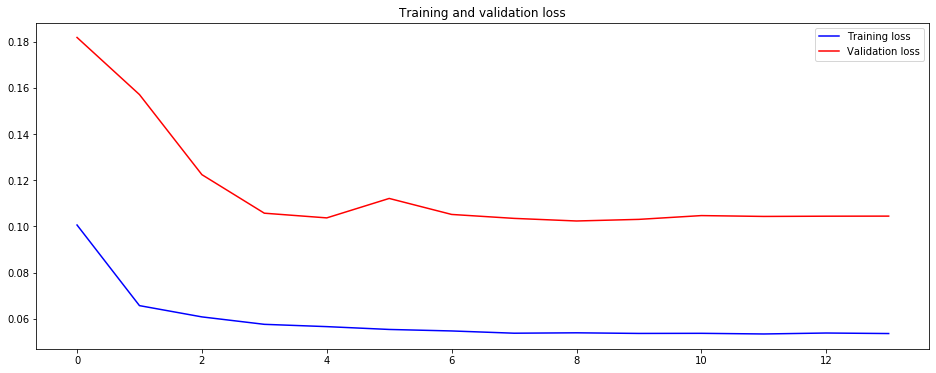

In [140]:
plot_train_history(history, 'Training and validation loss')

In [141]:
evaluate_model(testing_model, test_data, 'mae', ['mape', 'rmse'], 'testing_model')

,mae,mape,rmse,hyperparams
0,0.305422,16.70262,0.350071,testing_model


In [144]:
evaluate_model(baseline_model, test_data, 'mae', ['mape', 'rmse'], 'baseline')

,mae,mape,rmse,hyperparams
0,0.237063,14.072865,0.275527,baseline


History date range: 2018-05-08 00:00:00, 2018-06-19 00:00:00
Future date range: 2018-06-20 00:00:00, 2018-06-28 00:00:00


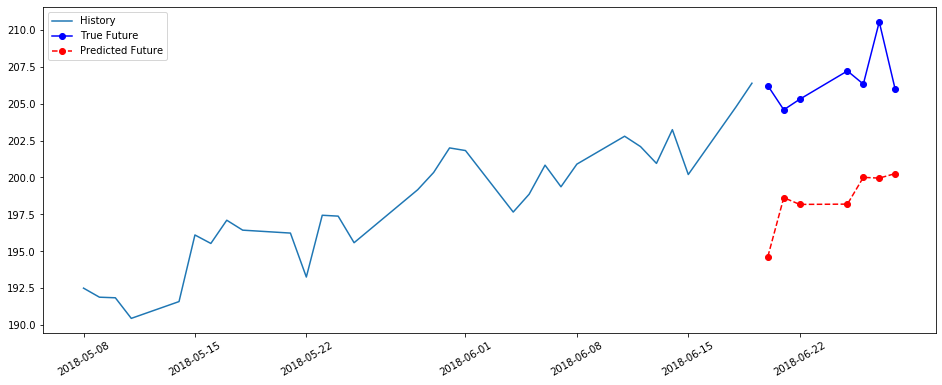

History date range: 2018-08-08 00:00:00, 2018-09-19 00:00:00
Future date range: 2018-09-20 00:00:00, 2018-09-28 00:00:00


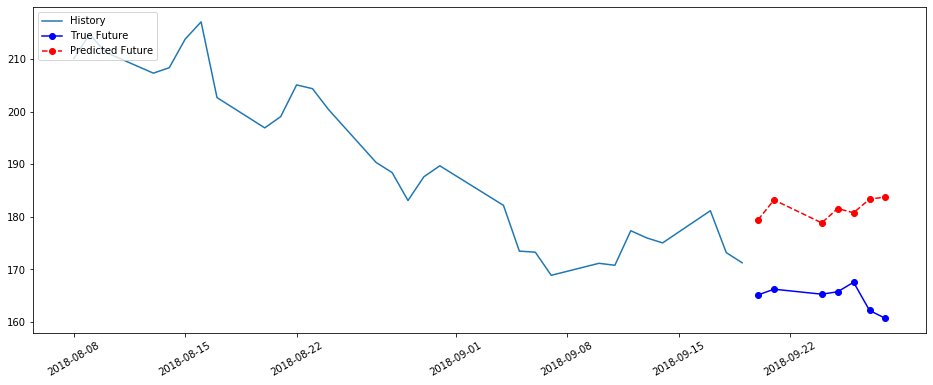

History date range: 2018-11-07 00:00:00, 2018-12-20 00:00:00
Future date range: 2018-12-21 00:00:00, 2019-01-02 00:00:00


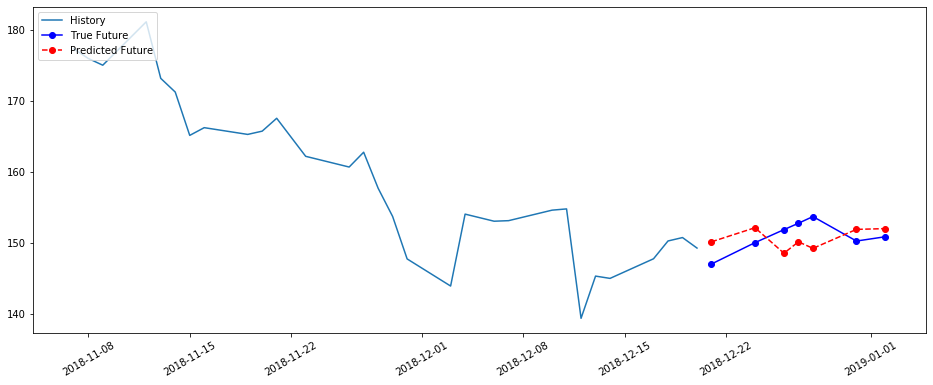

History date range: 2019-02-12 00:00:00, 2019-03-26 00:00:00
Future date range: 2019-03-27 00:00:00, 2019-04-04 00:00:00


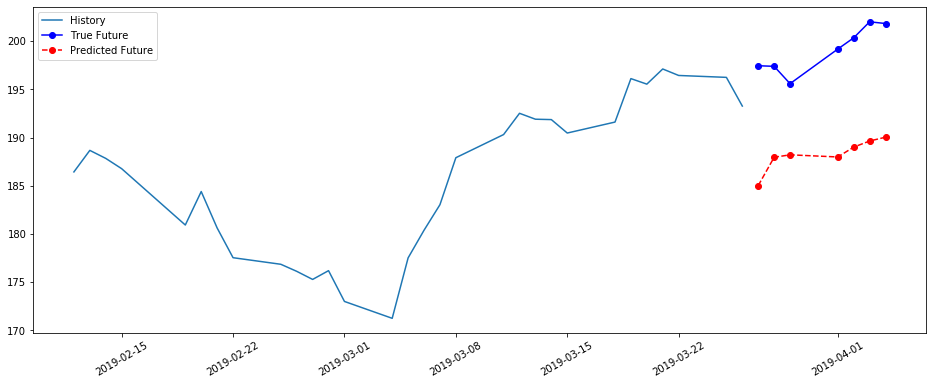

History date range: 2019-05-15 00:00:00, 2019-06-26 00:00:00
Future date range: 2019-06-27 00:00:00, 2019-07-08 00:00:00


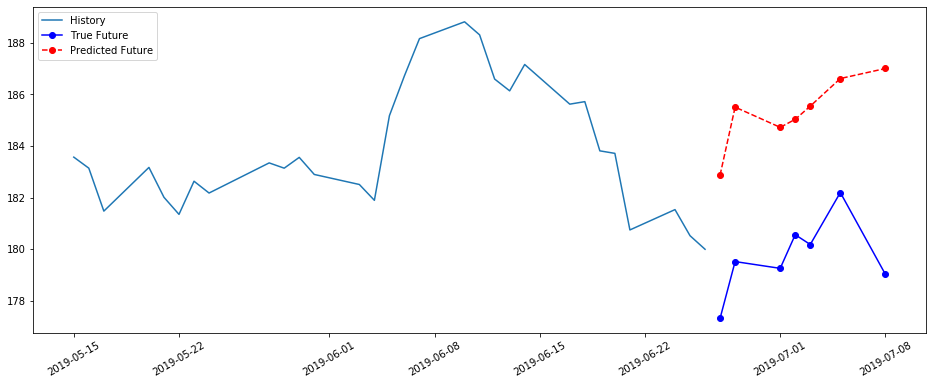

History date range: 2019-08-15 00:00:00, 2019-09-26 00:00:00
Future date range: 2019-09-27 00:00:00, 2019-10-07 00:00:00


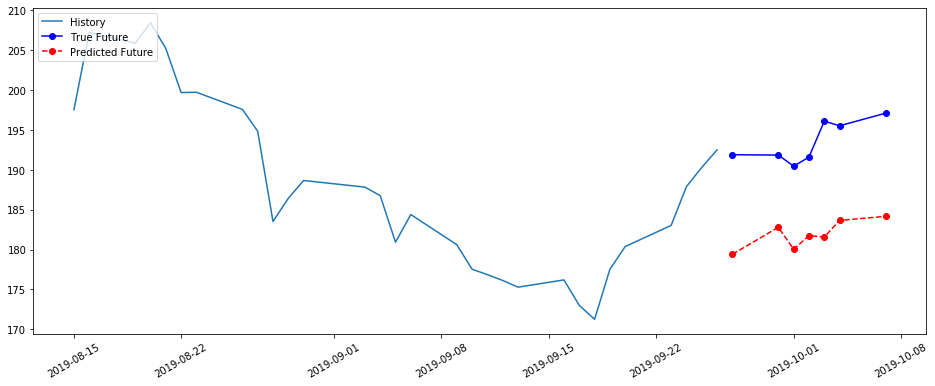

In [142]:
for xy, date in zip(val_data.take(6), val_dates.take(6)):
    
    x, y = xy
    x_dates, y_dates = date
    history = x[0].numpy()[:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
    true_future = return_original_scale(y[0], column_scaler['adjclose'])
    prediction = testing_model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(), true_future,
                          prediction_rescaled)

# GridSearch for Hyperparameters

In [85]:
def bidir_str(bidir):
    if bidir:
        return 'bidir' 
    else: 
        return ''

In [102]:
n_hidden = [2, 3, 4, 5, 6]
n_neurons = [8, 16, 32, 64]
learning_rate = np.arange(1e-3, 1e-1, 1e-3)
bidirectional = [True]

In [145]:
tensorboard_cb = TensorBoard(get_run_dir('logs'))
checkpointer_cb = ModelCheckpoint(get_run_dir('models'), save_best_only=True)
earlystopping_cb = EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)
cb_list = [earlystopping_cb, lr_scheduler]
dfsummary = []

for n_h in n_hidden:
    for n_n in n_neurons:
        for bidir in bidirectional:
            model_hyperparams = '_'.join([str(par) for par in [n_h, 'hidden', n_n, 'neurons', bidir_str(bidir)]])
            
            testing_model = build_model(n_hidden=n_h,
                                        n_neurons=n_n,
                                        bidirectional=bidir,
                                        input_shape=input_shape,
                                        output_layer_neurons=future_target)
            print('\n', '='*10, model_hyperparams, '='*10, '\n')
            testing_model.fit(
                train_data, epochs=50,
                steps_per_epoch=50,
                validation_data=val_data,
                validation_steps=50,
                callbacks=cb_list,
                verbose=1)
            summary = evaluate_model(testing_model, test_data, 'mae', ['mape', 'rmse'], model_hyperparams)
            print(summary)
            dfsummary.append(summary)


 ========== 2_hidden_8_neurons_bidir ========== 

Train for 50 steps, validate for 50 steps
Epoch 1/50
50/50 [==============================] - 13s 265ms/step - loss: 0.3135 - MeanAbsolutePercentageError: 31911.3262 - RootMeanSquaredError: 0.4077 - val_loss: 1.0034 - val_MeanAbsolutePercentageError: 84.8699 - val_RootMeanSquaredError: 1.0480
Epoch 2/50
50/50 [==============================] - 3s 56ms/step - loss: 0.2678 - MeanAbsolutePercentageError: 42561.7852 - RootMeanSquaredError: 0.3623 - val_loss: 0.9373 - val_MeanAbsolutePercentageError: 79.0176 - val_RootMeanSquaredError: 0.9862
Epoch 3/50
50/50 [==============================] - 3s 54ms/step - loss: 0.2463 - MeanAbsolutePercentageError: 48230.1016 - RootMeanSquaredError: 0.3389 - val_loss: 0.9019 - val_MeanAbsolutePercentageError: 75.8491 - val_RootMeanSquaredError: 0.9527
Epoch 4/50
50/50 [==============================] - 3s 62ms/step - loss: 0.2323 - MeanAbsolutePercentageError: 48472.8438 - RootMeanSquaredError: 0.3253 - 

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x00000252350082F0>
Traceback (most recent call last):
  File "C:\Users\jp_ko\Anaconda3\lib\weakref.py", line 357, in remove
    self = selfref()
KeyboardInterrupt


46/50 [==========================>...] - ETA: 6s - loss: 0.2089 - MeanAbsolutePercentageError: 51247.2031 - RootMeanSquaredError: 0.2832WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MeanAbsolutePercentageError,RootMeanSquaredError


KeyboardInterrupt: 

In [105]:
import time
print(time.now())

AttributeError: module 'time' has no attribute 'now'

# 4. Keras tuning

In [13]:
from kerastuner.tuners import RandomSearch


def build_model_for_tuning(hp, input_shape=(30, 6),
                           dropout=0.3, loss='mean_absolute_error', 
                           output_layer_neurons=future_target,
                           output_layer_activation='linear'):
    
    model = Sequential()
    
    # Get hyperparameters.
    n_hidden = hp.Int('num_layers', 2, 5)
    n_neurons = hp.Choice('units', values=[8, 16, 32, 64])
    lr = hp.Choice('learning_rate', values=[1e-5, 5e-5, 1e-4, 1e-3])
    
    # First layer.
    model.add(Bidirectional(LSTM(n_neurons, return_sequences=True),
                            input_shape=input_shape))
    
    # Hidden layers.
    for i in range(n_hidden):
        if i == n_hidden - 1:
            # Last hidden layer.
            model.add(Bidirectional(LSTM(n_neurons, return_sequences=False)))
        else:
            # Hidden layers
            model.add(Bidirectional(LSTM(n_neurons, return_sequences=True)))

        # Add dropout after each layer.
        model.add(Dropout(dropout))
    
    # Output layer.
    model.add(Dense(output_layer_neurons, activation=output_layer_activation))

    optimizer = keras.optimizers.Adam(lr)
    model.compile(loss=loss, optimizer=optimizer)

    return model

### Define a search space of hyperparameters

In [14]:
tuner = RandomSearch(
    build_model_for_tuning,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='tuner',
    project_name='first_model')

In [15]:
tuner.search_space_summary()

In [17]:
tuner.search(train_data,
             epochs=5,
             steps_per_epoch=200,
             validation_steps=50,
             validation_data=val_data, 
             verbose=1)

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - ETA: 40:08 - loss: 0.24 - ETA: 20:05 - loss: 0.22 - ETA: 13:23 - loss: 0.20 - ETA: 10:02 - loss: 0.20 - ETA: 8:02 - loss: 0.2044 - ETA: 6:41 - loss: 0.198 - ETA: 5:44 - loss: 0.196 - ETA: 5:01 - loss: 0.192 - ETA: 4:27 - loss: 0.200 - ETA: 4:00 - loss: 0.201 - ETA: 3:38 - loss: 0.199 - ETA: 3:20 - loss: 0.196 - ETA: 3:04 - loss: 0.197 - ETA: 2:51 - loss: 0.196 - ETA: 2:40 - loss: 0.193 - ETA: 2:29 - loss: 0.191 - ETA: 2:20 - loss: 0.190 - ETA: 2:12 - loss: 0.187 - ETA: 2:05 - loss: 0.185 - ETA: 1:59 - loss: 0.182 - ETA: 1:53 - loss: 0.180 - ETA: 1:48 - loss: 0.178 - ETA: 1:43 - loss: 0.175 - ETA: 1:39 - loss: 0.173 - ETA: 1:34 - loss: 0.172 - ETA: 1:31 - loss: 0.169 - ETA: 1:27 - loss: 0.166 - ETA: 1:24 - loss: 0.162 - ETA: 1:21 - loss: 0.159 - ETA: 1:18 - loss: 0.157 - ETA: 1:15 - loss: 0.155 - ETA: 1:13 - loss: 0.152 - ETA: 1:11 - loss: 0.151 - ETA: 1:08 - loss: 0.150 - ETA: 1:06 - loss: 0

200/200 [==============================] - ETA: 16s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 11s - loss: 0.05 - ETA: 11s - loss: 0.05 - ETA: 11s - loss: 0.05 - ETA: 11s - loss: 0.05 - ETA: 11s - loss: 0.05 - ETA: 11s - loss: 0.05 - ETA: 11s - loss: 0.05 - ETA: 11s - loss: 0.05 - ETA: 11s - loss: 0.05 - ETA: 11s - loss: 0.05 - ETA: 11s - loss: 0.05 - ETA: 11s - loss: 0.05 - ETA: 11s - loss: 0.05

200/200 [==============================] - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04

200/200 [==============================] - ETA: 12s - loss: 0.03 - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 0.03 - ETA: 12s - loss: 0.03 - ETA: 12s - loss: 0.03 - ETA: 12s - loss: 0.03 - ETA: 12s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04

200/200 [==============================] - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.02 - ETA: 11s - loss: 0.02 - ETA: 11s - loss: 0.02 - ETA: 11s - loss: 0.02 - ETA: 11s - loss: 0.02 - ETA: 11s - loss: 0.02 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 9s - loss: 0.0371 - ETA: 9s - loss: 0.037 - ETA: 9s - loss: 0.037 - ETA: 9s - loss: 0.037 - ETA: 9s - loss: 0.03

200/200 [==============================] - ETA: 36:40 - loss: 0.25 - ETA: 18:20 - loss: 0.24 - ETA: 12:13 - loss: 0.24 - ETA: 9:09 - loss: 0.2446 - ETA: 7:19 - loss: 0.231 - ETA: 6:06 - loss: 0.228 - ETA: 5:14 - loss: 0.228 - ETA: 4:34 - loss: 0.226 - ETA: 4:04 - loss: 0.228 - ETA: 3:39 - loss: 0.229 - ETA: 3:19 - loss: 0.227 - ETA: 3:02 - loss: 0.224 - ETA: 2:48 - loss: 0.223 - ETA: 2:36 - loss: 0.222 - ETA: 2:25 - loss: 0.222 - ETA: 2:16 - loss: 0.220 - ETA: 2:08 - loss: 0.219 - ETA: 2:01 - loss: 0.218 - ETA: 1:55 - loss: 0.217 - ETA: 1:49 - loss: 0.214 - ETA: 1:44 - loss: 0.212 - ETA: 1:39 - loss: 0.211 - ETA: 1:34 - loss: 0.209 - ETA: 1:30 - loss: 0.208 - ETA: 1:27 - loss: 0.206 - ETA: 1:24 - loss: 0.202 - ETA: 1:21 - loss: 0.198 - ETA: 1:18 - loss: 0.194 - ETA: 1:15 - loss: 0.191 - ETA: 1:12 - loss: 0.188 - ETA: 1:10 - loss: 0.186 - ETA: 1:08 - loss: 0.183 - ETA: 1:06 - loss: 0.181 - ETA: 1:04 - loss: 0.180 - ETA: 1:02 - loss: 0.179 - ETA: 1:00 - loss: 0.178 - ETA: 58s - loss: 0.1

200/200 [==============================] - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 9s - loss: 0.0622 - ETA: 9s - loss: 0.061 - ETA: 9s - loss: 0.061 - ETA: 9s - loss: 0.060 - ETA: 9s - loss: 0.059 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.06 - ETA: 10s - loss: 0.0

200/200 [==============================] - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 12s - loss: 0.03 - ETA: 13s - loss: 0.03 - ETA: 13s - loss: 0.03 - ETA: 13s - loss: 0.03 - ETA: 13s - loss: 0.03 - ETA: 13s - loss: 0.03 - ETA: 13s - loss: 0.04 - ETA: 13s - loss: 0.04 - ETA: 12s - loss: 0.04 - ETA: 12s - loss: 0.04 - ETA: 12s - loss: 0.04 - ETA: 12s - loss: 0.04 - ETA: 12s - loss: 0.04 - ETA: 12s - loss: 0.04 - ETA: 12s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.05 - ETA: 11s - loss: 0.05 - ETA: 11s - loss: 0.05 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04

200/200 [==============================] - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 12s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 9s - loss: 0.0434 - ETA: 9s - loss: 0.043 - ETA: 9s - loss: 0.04

200/200 [==============================] - ETA: 12s - loss: 0.02 - ETA: 12s - loss: 0.02 - ETA: 11s - loss: 0.02 - ETA: 12s - loss: 0.03 - ETA: 12s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 9s - loss: 0.0394 - ETA: 9s - loss: 0.039 - ETA: 9s - loss: 0.039 - ETA: 9s - loss: 0.03

200/200 [==============================] - ETA: 38:23 - loss: 0.24 - ETA: 19:11 - loss: 0.24 - ETA: 12:47 - loss: 0.23 - ETA: 9:35 - loss: 0.2235 - ETA: 7:40 - loss: 0.225 - ETA: 6:23 - loss: 0.223 - ETA: 5:28 - loss: 0.220 - ETA: 4:47 - loss: 0.220 - ETA: 4:15 - loss: 0.222 - ETA: 3:49 - loss: 0.221 - ETA: 3:28 - loss: 0.219 - ETA: 3:11 - loss: 0.218 - ETA: 2:56 - loss: 0.215 - ETA: 2:43 - loss: 0.216 - ETA: 2:32 - loss: 0.216 - ETA: 2:23 - loss: 0.213 - ETA: 2:14 - loss: 0.212 - ETA: 2:06 - loss: 0.210 - ETA: 2:00 - loss: 0.207 - ETA: 1:54 - loss: 0.205 - ETA: 1:48 - loss: 0.202 - ETA: 1:43 - loss: 0.199 - ETA: 1:38 - loss: 0.196 - ETA: 1:34 - loss: 0.193 - ETA: 1:30 - loss: 0.190 - ETA: 1:27 - loss: 0.186 - ETA: 1:24 - loss: 0.182 - ETA: 1:20 - loss: 0.179 - ETA: 1:18 - loss: 0.175 - ETA: 1:15 - loss: 0.172 - ETA: 1:12 - loss: 0.170 - ETA: 1:10 - loss: 0.167 - ETA: 1:08 - loss: 0.166 - ETA: 1:06 - loss: 0.164 - ETA: 1:04 - loss: 0.162 - ETA: 1:02 - loss: 0.161 - ETA: 1:00 - loss: 0.

200/200 [==============================] - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.04 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05

200/200 [==============================] - ETA: 12s - loss: 0.03 - ETA: 12s - loss: 0.03 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.05 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 9s - loss: 0.0480 - ETA: 9s - loss: 0.048 - ETA: 9s - loss: 0.048 - ETA: 9s - loss: 0.048 - ETA: 9s - loss: 0.04

200/200 [==============================] - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 9s - loss: 0.0433 - ETA: 9s - loss: 0.043 - ETA: 9s - loss: 0.043 - ETA: 9s - loss: 0.043 - ETA: 9s - loss: 0.04

200/200 [==============================] - ETA: 11s - loss: 0.02 - ETA: 11s - loss: 0.02 - ETA: 11s - loss: 0.02 - ETA: 11s - loss: 0.02 - ETA: 11s - loss: 0.02 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.03 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 11s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 10s - loss: 0.04 - ETA: 9s - loss: 0.0418 - ETA: 9s - loss: 0.041 - ETA: 9s - loss: 0.041 - ETA: 9s - loss: 0.041 - ETA: 9s - loss: 0.042 - ETA: 9s - loss: 0.04

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - ETA: 38:50 - loss: 0.24 - ETA: 19:26 - loss: 0.24 - ETA: 12:58 - loss: 0.24 - ETA: 9:44 - loss: 0.2474 - ETA: 7:48 - loss: 0.248 - ETA: 6:31 - loss: 0.256 - ETA: 5:35 - loss: 0.266 - ETA: 4:54 - loss: 0.278 - ETA: 4:22 - loss: 0.290 - ETA: 3:56 - loss: 0.298 - ETA: 3:35 - loss: 0.302 - ETA: 3:17 - loss: 0.306 - ETA: 3:02 - loss: 0.306 - ETA: 2:49 - loss: 0.313 - ETA: 2:38 - loss: 0.316 - ETA: 2:29 - loss: 0.322 - ETA: 2:20 - loss: 0.325 - ETA: 2:12 - loss: 0.328 - ETA: 2:05 - loss: 0.329 - ETA: 1:59 - loss: 0.330 - ETA: 1:54 - loss: 0.332 - ETA: 1:49 - loss: 0.332 - ETA: 1:44 - loss: 0.332 - ETA: 1:40 - loss: 0.333 - ETA: 1:35 - loss: 0.329 - ETA: 1:32 - loss: 0.324 - ETA: 1:28 - loss: 0.318 - ETA: 1:25 - loss: 0.314 - ETA: 1:22 - loss: 0.310 - ETA: 1:19 - loss: 0.306 - ETA: 1:17 - loss: 0.303 - ETA: 1:14 - loss: 0.302 - ETA: 1:12 - loss: 0.301 - ETA: 1:10 - loss: 0.301 - ETA: 1:08 - loss: 0

200/200 [==============================] - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09

200/200 [==============================] - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08

200/200 [==============================] - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07

200/200 [==============================] - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06

200/200 [==============================] - ETA: 38:01 - loss: 0.28 - ETA: 19:03 - loss: 0.28 - ETA: 12:43 - loss: 0.27 - ETA: 9:33 - loss: 0.2790 - ETA: 7:38 - loss: 0.283 - ETA: 6:22 - loss: 0.280 - ETA: 5:28 - loss: 0.289 - ETA: 4:47 - loss: 0.302 - ETA: 4:16 - loss: 0.320 - ETA: 3:50 - loss: 0.322 - ETA: 3:29 - loss: 0.332 - ETA: 3:12 - loss: 0.337 - ETA: 2:57 - loss: 0.344 - ETA: 2:45 - loss: 0.348 - ETA: 2:34 - loss: 0.349 - ETA: 2:24 - loss: 0.351 - ETA: 2:16 - loss: 0.351 - ETA: 2:08 - loss: 0.349 - ETA: 2:02 - loss: 0.350 - ETA: 1:56 - loss: 0.351 - ETA: 1:50 - loss: 0.351 - ETA: 1:45 - loss: 0.351 - ETA: 1:41 - loss: 0.349 - ETA: 1:36 - loss: 0.348 - ETA: 1:32 - loss: 0.345 - ETA: 1:29 - loss: 0.339 - ETA: 1:25 - loss: 0.333 - ETA: 1:22 - loss: 0.327 - ETA: 1:20 - loss: 0.322 - ETA: 1:17 - loss: 0.318 - ETA: 1:14 - loss: 0.314 - ETA: 1:12 - loss: 0.311 - ETA: 1:10 - loss: 0.310 - ETA: 1:08 - loss: 0.309 - ETA: 1:06 - loss: 0.308 - ETA: 1:04 - loss: 0.307 - ETA: 1:02 - loss: 0.

200/200 [==============================] - ETA: 16s - loss: 0.06 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09

200/200 [==============================] - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07

200/200 [==============================] - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07

200/200 [==============================] - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06

200/200 [==============================] - ETA: 34:04 - loss: 0.25 - ETA: 17:04 - loss: 0.25 - ETA: 11:24 - loss: 0.24 - ETA: 8:35 - loss: 0.2518 - ETA: 6:53 - loss: 0.254 - ETA: 5:45 - loss: 0.263 - ETA: 4:56 - loss: 0.269 - ETA: 4:20 - loss: 0.278 - ETA: 3:52 - loss: 0.288 - ETA: 3:29 - loss: 0.297 - ETA: 3:10 - loss: 0.306 - ETA: 2:55 - loss: 0.310 - ETA: 2:42 - loss: 0.318 - ETA: 2:31 - loss: 0.320 - ETA: 2:21 - loss: 0.321 - ETA: 2:12 - loss: 0.324 - ETA: 2:05 - loss: 0.329 - ETA: 1:58 - loss: 0.335 - ETA: 1:52 - loss: 0.336 - ETA: 1:47 - loss: 0.336 - ETA: 1:42 - loss: 0.339 - ETA: 1:37 - loss: 0.341 - ETA: 1:33 - loss: 0.341 - ETA: 1:29 - loss: 0.341 - ETA: 1:26 - loss: 0.338 - ETA: 1:23 - loss: 0.333 - ETA: 1:20 - loss: 0.328 - ETA: 1:17 - loss: 0.323 - ETA: 1:14 - loss: 0.318 - ETA: 1:12 - loss: 0.315 - ETA: 1:09 - loss: 0.312 - ETA: 1:07 - loss: 0.310 - ETA: 1:05 - loss: 0.311 - ETA: 1:03 - loss: 0.311 - ETA: 1:01 - loss: 0.310 - ETA: 1:00 - loss: 0.310 - ETA: 58s - loss: 0.3

200/200 [==============================] - ETA: 14s - loss: 0.06 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08

200/200 [==============================] - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07

200/200 [==============================] - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06 - ETA: 11s - loss: 0.06

200/200 [==============================] - ETA: 12s - loss: 0.05 - ETA: 12s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 13s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 12s - loss: 0.06

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - ETA: 21:29 - loss: 0.24 - ETA: 7:09 - loss: 0.2587 - ETA: 4:17 - loss: 0.269 - ETA: 3:04 - loss: 0.278 - ETA: 2:23 - loss: 0.299 - ETA: 1:57 - loss: 0.315 - ETA: 1:38 - loss: 0.334 - ETA: 1:25 - loss: 0.345 - ETA: 1:15 - loss: 0.353 - ETA: 1:07 - loss: 0.356 - ETA: 1:00 - loss: 0.363 - ETA: 55s - loss: 0.369 - ETA: 50s - loss: 0.37 - ETA: 46s - loss: 0.36 - ETA: 43s - loss: 0.35 - ETA: 40s - loss: 0.35 - ETA: 38s - loss: 0.35 - ETA: 35s - loss: 0.35 - ETA: 34s - loss: 0.35 - ETA: 32s - loss: 0.35 - ETA: 30s - loss: 0.36 - ETA: 29s - loss: 0.36 - ETA: 27s - loss: 0.36 - ETA: 26s - loss: 0.37 - ETA: 25s - loss: 0.37 - ETA: 24s - loss: 0.37 - ETA: 23s - loss: 0.36 - ETA: 22s - loss: 0.36 - ETA: 22s - loss: 0.36 - ETA: 21s - loss: 0.36 - ETA: 20s - loss: 0.36 - ETA: 19s - loss: 0.36 - ETA: 19s - loss: 0.36 - ETA: 18s - loss: 0.36 - ETA: 17s - loss: 0.36 - ETA: 17s - loss: 0.36 - ETA: 16s - loss:

200/200 [==============================] - ETA: 6s - loss: 0.170 - ETA: 6s - loss: 0.175 - ETA: 6s - loss: 0.185 - ETA: 6s - loss: 0.212 - ETA: 6s - loss: 0.239 - ETA: 6s - loss: 0.257 - ETA: 6s - loss: 0.271 - ETA: 6s - loss: 0.281 - ETA: 6s - loss: 0.285 - ETA: 6s - loss: 0.289 - ETA: 6s - loss: 0.296 - ETA: 6s - loss: 0.299 - ETA: 6s - loss: 0.301 - ETA: 6s - loss: 0.291 - ETA: 5s - loss: 0.286 - ETA: 5s - loss: 0.281 - ETA: 5s - loss: 0.282 - ETA: 5s - loss: 0.286 - ETA: 5s - loss: 0.289 - ETA: 5s - loss: 0.291 - ETA: 5s - loss: 0.292 - ETA: 5s - loss: 0.295 - ETA: 5s - loss: 0.297 - ETA: 5s - loss: 0.298 - ETA: 5s - loss: 0.299 - ETA: 5s - loss: 0.296 - ETA: 5s - loss: 0.292 - ETA: 5s - loss: 0.288 - ETA: 4s - loss: 0.286 - ETA: 4s - loss: 0.288 - ETA: 4s - loss: 0.289 - ETA: 4s - loss: 0.291 - ETA: 4s - loss: 0.291 - ETA: 4s - loss: 0.292 - ETA: 4s - loss: 0.294 - ETA: 4s - loss: 0.295 - ETA: 4s - loss: 0.296 - ETA: 4s - loss: 0.297 - ETA: 4s - loss: 0.294 - ETA: 4s - loss: 0.292

200/200 [==============================] - ETA: 5s - loss: 0.207 - ETA: 6s - loss: 0.255 - ETA: 6s - loss: 0.263 - ETA: 6s - loss: 0.281 - ETA: 6s - loss: 0.312 - ETA: 6s - loss: 0.324 - ETA: 6s - loss: 0.331 - ETA: 6s - loss: 0.338 - ETA: 6s - loss: 0.347 - ETA: 6s - loss: 0.353 - ETA: 6s - loss: 0.360 - ETA: 6s - loss: 0.366 - ETA: 6s - loss: 0.371 - ETA: 6s - loss: 0.363 - ETA: 5s - loss: 0.355 - ETA: 5s - loss: 0.352 - ETA: 5s - loss: 0.351 - ETA: 5s - loss: 0.355 - ETA: 5s - loss: 0.358 - ETA: 5s - loss: 0.361 - ETA: 5s - loss: 0.362 - ETA: 5s - loss: 0.364 - ETA: 5s - loss: 0.367 - ETA: 5s - loss: 0.368 - ETA: 5s - loss: 0.369 - ETA: 5s - loss: 0.367 - ETA: 5s - loss: 0.362 - ETA: 5s - loss: 0.359 - ETA: 4s - loss: 0.358 - ETA: 4s - loss: 0.360 - ETA: 4s - loss: 0.361 - ETA: 4s - loss: 0.363 - ETA: 4s - loss: 0.365 - ETA: 4s - loss: 0.365 - ETA: 4s - loss: 0.366 - ETA: 4s - loss: 0.367 - ETA: 4s - loss: 0.368 - ETA: 4s - loss: 0.368 - ETA: 4s - loss: 0.365 - ETA: 4s - loss: 0.362

200/200 [==============================] - ETA: 6s - loss: 0.183 - ETA: 6s - loss: 0.201 - ETA: 6s - loss: 0.212 - ETA: 6s - loss: 0.221 - ETA: 6s - loss: 0.237 - ETA: 6s - loss: 0.260 - ETA: 6s - loss: 0.273 - ETA: 6s - loss: 0.276 - ETA: 6s - loss: 0.281 - ETA: 6s - loss: 0.287 - ETA: 5s - loss: 0.292 - ETA: 5s - loss: 0.294 - ETA: 5s - loss: 0.296 - ETA: 5s - loss: 0.289 - ETA: 5s - loss: 0.284 - ETA: 5s - loss: 0.279 - ETA: 5s - loss: 0.278 - ETA: 5s - loss: 0.281 - ETA: 5s - loss: 0.282 - ETA: 5s - loss: 0.284 - ETA: 5s - loss: 0.286 - ETA: 5s - loss: 0.288 - ETA: 5s - loss: 0.290 - ETA: 5s - loss: 0.292 - ETA: 5s - loss: 0.295 - ETA: 4s - loss: 0.292 - ETA: 4s - loss: 0.289 - ETA: 4s - loss: 0.286 - ETA: 4s - loss: 0.285 - ETA: 4s - loss: 0.285 - ETA: 4s - loss: 0.287 - ETA: 4s - loss: 0.287 - ETA: 4s - loss: 0.288 - ETA: 4s - loss: 0.290 - ETA: 4s - loss: 0.291 - ETA: 4s - loss: 0.291 - ETA: 4s - loss: 0.293 - ETA: 4s - loss: 0.295 - ETA: 4s - loss: 0.291 - ETA: 4s - loss: 0.289

200/200 [==============================] - ETA: 6s - loss: 0.233 - ETA: 6s - loss: 0.213 - ETA: 6s - loss: 0.215 - ETA: 6s - loss: 0.222 - ETA: 6s - loss: 0.249 - ETA: 6s - loss: 0.268 - ETA: 6s - loss: 0.281 - ETA: 6s - loss: 0.291 - ETA: 6s - loss: 0.299 - ETA: 5s - loss: 0.304 - ETA: 5s - loss: 0.312 - ETA: 5s - loss: 0.314 - ETA: 5s - loss: 0.319 - ETA: 5s - loss: 0.313 - ETA: 5s - loss: 0.307 - ETA: 5s - loss: 0.304 - ETA: 5s - loss: 0.303 - ETA: 5s - loss: 0.303 - ETA: 5s - loss: 0.307 - ETA: 5s - loss: 0.310 - ETA: 5s - loss: 0.310 - ETA: 5s - loss: 0.313 - ETA: 5s - loss: 0.313 - ETA: 5s - loss: 0.313 - ETA: 4s - loss: 0.315 - ETA: 4s - loss: 0.313 - ETA: 4s - loss: 0.309 - ETA: 4s - loss: 0.306 - ETA: 4s - loss: 0.305 - ETA: 4s - loss: 0.305 - ETA: 4s - loss: 0.308 - ETA: 4s - loss: 0.309 - ETA: 4s - loss: 0.311 - ETA: 4s - loss: 0.312 - ETA: 4s - loss: 0.313 - ETA: 4s - loss: 0.313 - ETA: 4s - loss: 0.314 - ETA: 4s - loss: 0.314 - ETA: 4s - loss: 0.311 - ETA: 3s - loss: 0.309

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - ETA: 27:09 - loss: 0.25 - ETA: 13:38 - loss: 0.26 - ETA: 9:08 - loss: 0.2735 - ETA: 6:53 - loss: 0.278 - ETA: 5:32 - loss: 0.284 - ETA: 4:38 - loss: 0.289 - ETA: 3:59 - loss: 0.300 - ETA: 3:30 - loss: 0.310 - ETA: 3:07 - loss: 0.326 - ETA: 2:49 - loss: 0.336 - ETA: 2:34 - loss: 0.339 - ETA: 2:22 - loss: 0.348 - ETA: 2:12 - loss: 0.346 - ETA: 2:03 - loss: 0.344 - ETA: 1:55 - loss: 0.346 - ETA: 1:48 - loss: 0.346 - ETA: 1:42 - loss: 0.347 - ETA: 1:36 - loss: 0.347 - ETA: 1:32 - loss: 0.345 - ETA: 1:27 - loss: 0.343 - ETA: 1:23 - loss: 0.343 - ETA: 1:20 - loss: 0.344 - ETA: 1:16 - loss: 0.344 - ETA: 1:13 - loss: 0.343 - ETA: 1:10 - loss: 0.340 - ETA: 1:08 - loss: 0.333 - ETA: 1:06 - loss: 0.327 - ETA: 1:03 - loss: 0.322 - ETA: 1:01 - loss: 0.316 - ETA: 1:00 - loss: 0.311 - ETA: 58s - loss: 0.307 - ETA: 56s - loss: 0.30 - ETA: 55s - loss: 0.30 - ETA: 53s - loss: 0.29 - ETA: 52s - loss: 0.29 - ET

200/200 [==============================] - ETA: 20s - loss: 0.05 - ETA: 19s - loss: 0.05 - ETA: 20s - loss: 0.05 - ETA: 20s - loss: 0.05 - ETA: 20s - loss: 0.05 - ETA: 20s - loss: 0.05 - ETA: 20s - loss: 0.05 - ETA: 20s - loss: 0.05 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06

200/200 [==============================] - ETA: 15s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05

200/200 [==============================] - ETA: 16s - loss: 0.03 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 13s - loss: 0.05

200/200 [==============================] - ETA: 16s - loss: 0.03 - ETA: 15s - loss: 0.03 - ETA: 15s - loss: 0.03 - ETA: 15s - loss: 0.03 - ETA: 15s - loss: 0.04 - ETA: 15s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 15s - loss: 0.04 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05

200/200 [==============================] - ETA: 27:31 - loss: 0.28 - ETA: 13:49 - loss: 0.27 - ETA: 9:16 - loss: 0.2716 - ETA: 6:59 - loss: 0.279 - ETA: 5:36 - loss: 0.289 - ETA: 4:41 - loss: 0.295 - ETA: 4:02 - loss: 0.294 - ETA: 3:33 - loss: 0.309 - ETA: 3:10 - loss: 0.323 - ETA: 2:52 - loss: 0.332 - ETA: 2:36 - loss: 0.344 - ETA: 2:24 - loss: 0.350 - ETA: 2:13 - loss: 0.353 - ETA: 2:04 - loss: 0.354 - ETA: 1:56 - loss: 0.356 - ETA: 1:49 - loss: 0.355 - ETA: 1:43 - loss: 0.353 - ETA: 1:38 - loss: 0.355 - ETA: 1:33 - loss: 0.355 - ETA: 1:29 - loss: 0.354 - ETA: 1:25 - loss: 0.352 - ETA: 1:21 - loss: 0.350 - ETA: 1:18 - loss: 0.350 - ETA: 1:15 - loss: 0.350 - ETA: 1:12 - loss: 0.348 - ETA: 1:10 - loss: 0.342 - ETA: 1:07 - loss: 0.335 - ETA: 1:05 - loss: 0.329 - ETA: 1:03 - loss: 0.323 - ETA: 1:01 - loss: 0.319 - ETA: 1:00 - loss: 0.316 - ETA: 58s - loss: 0.313 - ETA: 56s - loss: 0.31 - ETA: 55s - loss: 0.30 - ETA: 53s - loss: 0.30 - ETA: 52s - loss: 0.30 - ETA: 51s - loss: 0.30 - ETA: 

200/200 [==============================] - ETA: 20s - loss: 0.05 - ETA: 20s - loss: 0.05 - ETA: 21s - loss: 0.05 - ETA: 21s - loss: 0.05 - ETA: 21s - loss: 0.05 - ETA: 20s - loss: 0.05 - ETA: 20s - loss: 0.05 - ETA: 20s - loss: 0.05 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 20s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 19s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06

200/200 [==============================] - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 14s - loss: 0.06 - ETA: 13s - loss: 0.06

200/200 [==============================] - ETA: 17s - loss: 0.04 - ETA: 17s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 17s - loss: 0.04 - ETA: 17s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 13s - loss: 0.05 - ETA: 13s - loss: 0.05

200/200 [==============================] - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05

200/200 [==============================] - ETA: 27:40 - loss: 0.26 - ETA: 13:55 - loss: 0.27 - ETA: 9:20 - loss: 0.2742 - ETA: 7:03 - loss: 0.282 - ETA: 5:40 - loss: 0.284 - ETA: 4:45 - loss: 0.287 - ETA: 4:06 - loss: 0.287 - ETA: 3:37 - loss: 0.295 - ETA: 3:14 - loss: 0.305 - ETA: 2:56 - loss: 0.317 - ETA: 2:41 - loss: 0.324 - ETA: 2:29 - loss: 0.324 - ETA: 2:18 - loss: 0.325 - ETA: 2:09 - loss: 0.325 - ETA: 2:01 - loss: 0.327 - ETA: 1:54 - loss: 0.327 - ETA: 1:48 - loss: 0.329 - ETA: 1:43 - loss: 0.330 - ETA: 1:38 - loss: 0.329 - ETA: 1:33 - loss: 0.329 - ETA: 1:29 - loss: 0.326 - ETA: 1:26 - loss: 0.323 - ETA: 1:22 - loss: 0.321 - ETA: 1:19 - loss: 0.321 - ETA: 1:16 - loss: 0.315 - ETA: 1:13 - loss: 0.308 - ETA: 1:11 - loss: 0.302 - ETA: 1:09 - loss: 0.296 - ETA: 1:07 - loss: 0.291 - ETA: 1:05 - loss: 0.287 - ETA: 1:03 - loss: 0.282 - ETA: 1:01 - loss: 0.279 - ETA: 59s - loss: 0.275 - ETA: 58s - loss: 0.27 - ETA: 56s - loss: 0.27 - ETA: 55s - loss: 0.26 - ETA: 53s - loss: 0.26 - ETA

200/200 [==============================] - ETA: 17s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 17s - loss: 0.05 - ETA: 17s - loss: 0.05 - ETA: 17s - loss: 0.05 - ETA: 18s - loss: 0.05 - ETA: 18s - loss: 0.05 - ETA: 18s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 19s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 18s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 17s - loss: 0.06 - ETA: 16s - loss: 0.06

200/200 [==============================] - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.06 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05

200/200 [==============================] - ETA: 15s - loss: 0.03 - ETA: 15s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05

200/200 [==============================] - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 16s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 15s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05 - ETA: 14s - loss: 0.05

Train for 200 steps, validate for 50 steps
Epoch 1/5
200/200 [==============================] - ETA: 20:46 - loss: 0.24 - ETA: 6:55 - loss: 0.2428 - ETA: 4:09 - loss: 0.242 - ETA: 2:58 - loss: 0.255 - ETA: 2:18 - loss: 0.269 - ETA: 1:53 - loss: 0.280 - ETA: 1:35 - loss: 0.283 - ETA: 1:23 - loss: 0.291 - ETA: 1:13 - loss: 0.288 - ETA: 1:05 - loss: 0.284 - ETA: 59s - loss: 0.280 - ETA: 54s - loss: 0.27 - ETA: 49s - loss: 0.27 - ETA: 45s - loss: 0.26 - ETA: 42s - loss: 0.25 - ETA: 39s - loss: 0.24 - ETA: 37s - loss: 0.23 - ETA: 35s - loss: 0.23 - ETA: 33s - loss: 0.23 - ETA: 31s - loss: 0.23 - ETA: 29s - loss: 0.22 - ETA: 28s - loss: 0.22 - ETA: 26s - loss: 0.22 - ETA: 25s - loss: 0.22 - ETA: 24s - loss: 0.21 - ETA: 23s - loss: 0.21 - ETA: 22s - loss: 0.20 - ETA: 21s - loss: 0.20 - ETA: 20s - loss: 0.20 - ETA: 19s - loss: 0.19 - ETA: 19s - loss: 0.19 - ETA: 18s - loss: 0.19 - ETA: 17s - loss: 0.19 - ETA: 17s - loss: 0.19 - ETA: 16s - loss: 0.19 - ETA: 16s - loss: 0.18 - ETA: 15s - loss: 0

200/200 [==============================] - ETA: 6s - loss: 0.038 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.040 - ETA: 7s - loss: 0.042 - ETA: 6s - loss: 0.044 - ETA: 6s - loss: 0.048 - ETA: 6s - loss: 0.050 - ETA: 6s - loss: 0.050 - ETA: 6s - loss: 0.052 - ETA: 6s - loss: 0.052 - ETA: 6s - loss: 0.052 - ETA: 6s - loss: 0.052 - ETA: 6s - loss: 0.051 - ETA: 6s - loss: 0.050 - ETA: 6s - loss: 0.049 - ETA: 6s - loss: 0.049 - ETA: 6s - loss: 0.049 - ETA: 6s - loss: 0.050 - ETA: 6s - loss: 0.050 - ETA: 5s - loss: 0.051 - ETA: 5s - loss: 0.051 - ETA: 5s - loss: 0.052 - ETA: 5s - loss: 0.052 - ETA: 5s - loss: 0.052 - ETA: 5s - loss: 0.051 - ETA: 5s - loss: 0.051 - ETA: 5s - loss: 0.050 - ETA: 5s - loss: 0.050 - ETA: 5s - loss: 0.050 - ETA: 5s - loss: 0.050 - ETA: 5s - loss: 0.050 - ETA: 5s - loss: 0.050 - ETA: 5s - loss: 0.051 - ETA: 4s - loss: 0.051 - ETA: 4s - loss: 0.051 - ETA: 4s - loss: 0.051 - ETA: 4s - loss: 0.052 - ETA: 4s - loss: 0.051 - ETA: 4s - loss: 0.051

200/200 [==============================] - ETA: 6s - loss: 0.056 - ETA: 6s - loss: 0.054 - ETA: 6s - loss: 0.055 - ETA: 6s - loss: 0.059 - ETA: 6s - loss: 0.063 - ETA: 6s - loss: 0.067 - ETA: 6s - loss: 0.071 - ETA: 6s - loss: 0.074 - ETA: 6s - loss: 0.075 - ETA: 6s - loss: 0.076 - ETA: 6s - loss: 0.077 - ETA: 6s - loss: 0.078 - ETA: 6s - loss: 0.079 - ETA: 6s - loss: 0.077 - ETA: 6s - loss: 0.076 - ETA: 6s - loss: 0.075 - ETA: 6s - loss: 0.074 - ETA: 5s - loss: 0.075 - ETA: 5s - loss: 0.076 - ETA: 5s - loss: 0.077 - ETA: 5s - loss: 0.077 - ETA: 5s - loss: 0.077 - ETA: 5s - loss: 0.077 - ETA: 5s - loss: 0.078 - ETA: 5s - loss: 0.078 - ETA: 5s - loss: 0.078 - ETA: 5s - loss: 0.076 - ETA: 5s - loss: 0.076 - ETA: 5s - loss: 0.075 - ETA: 5s - loss: 0.075 - ETA: 5s - loss: 0.075 - ETA: 5s - loss: 0.075 - ETA: 4s - loss: 0.075 - ETA: 4s - loss: 0.076 - ETA: 4s - loss: 0.076 - ETA: 4s - loss: 0.076 - ETA: 4s - loss: 0.076 - ETA: 4s - loss: 0.077 - ETA: 4s - loss: 0.076 - ETA: 4s - loss: 0.075

200/200 [==============================] - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.036 - ETA: 7s - loss: 0.037 - ETA: 7s - loss: 0.039 - ETA: 7s - loss: 0.040 - ETA: 6s - loss: 0.041 - ETA: 6s - loss: 0.043 - ETA: 6s - loss: 0.044 - ETA: 6s - loss: 0.045 - ETA: 6s - loss: 0.046 - ETA: 6s - loss: 0.046 - ETA: 6s - loss: 0.046 - ETA: 6s - loss: 0.045 - ETA: 6s - loss: 0.044 - ETA: 6s - loss: 0.044 - ETA: 6s - loss: 0.044 - ETA: 6s - loss: 0.044 - ETA: 5s - loss: 0.045 - ETA: 5s - loss: 0.045 - ETA: 5s - loss: 0.045 - ETA: 5s - loss: 0.045 - ETA: 5s - loss: 0.045 - ETA: 5s - loss: 0.045 - ETA: 5s - loss: 0.045 - ETA: 5s - loss: 0.046 - ETA: 5s - loss: 0.045 - ETA: 5s - loss: 0.045 - ETA: 5s - loss: 0.044 - ETA: 5s - loss: 0.045 - ETA: 5s - loss: 0.045 - ETA: 5s - loss: 0.045 - ETA: 4s - loss: 0.045 - ETA: 4s - loss: 0.045 - ETA: 4s - loss: 0.045 - ETA: 4s - loss: 0.045 - ETA: 4s - loss: 0.045 - ETA: 4s - loss: 0.046 - ETA: 4s - loss: 0.045 - ETA: 4s - loss: 0.045

200/200 [==============================] - ETA: 7s - loss: 0.046 - ETA: 7s - loss: 0.046 - ETA: 7s - loss: 0.045 - ETA: 7s - loss: 0.047 - ETA: 6s - loss: 0.051 - ETA: 6s - loss: 0.055 - ETA: 6s - loss: 0.058 - ETA: 6s - loss: 0.060 - ETA: 6s - loss: 0.060 - ETA: 6s - loss: 0.060 - ETA: 6s - loss: 0.061 - ETA: 6s - loss: 0.061 - ETA: 6s - loss: 0.061 - ETA: 6s - loss: 0.060 - ETA: 6s - loss: 0.059 - ETA: 6s - loss: 0.058 - ETA: 6s - loss: 0.057 - ETA: 5s - loss: 0.058 - ETA: 5s - loss: 0.059 - ETA: 5s - loss: 0.060 - ETA: 5s - loss: 0.060 - ETA: 5s - loss: 0.060 - ETA: 5s - loss: 0.060 - ETA: 5s - loss: 0.060 - ETA: 5s - loss: 0.060 - ETA: 5s - loss: 0.060 - ETA: 5s - loss: 0.059 - ETA: 5s - loss: 0.058 - ETA: 5s - loss: 0.058 - ETA: 5s - loss: 0.058 - ETA: 5s - loss: 0.058 - ETA: 4s - loss: 0.058 - ETA: 4s - loss: 0.059 - ETA: 4s - loss: 0.059 - ETA: 4s - loss: 0.059 - ETA: 4s - loss: 0.059 - ETA: 4s - loss: 0.059 - ETA: 4s - loss: 0.059 - ETA: 4s - loss: 0.059 - ETA: 4s - loss: 0.058

INFO:tensorflow:Oracle triggered exit


In [18]:
tuner.results_summary(num_trials=1)

In [20]:
best_model = tuner.get_best_models(num_models=1)[0]

History date range: 2020-03-16 00:00:00, 2020-04-27 00:00:00
Future date range: 2020-04-28 00:00:00, 2020-05-06 00:00:00


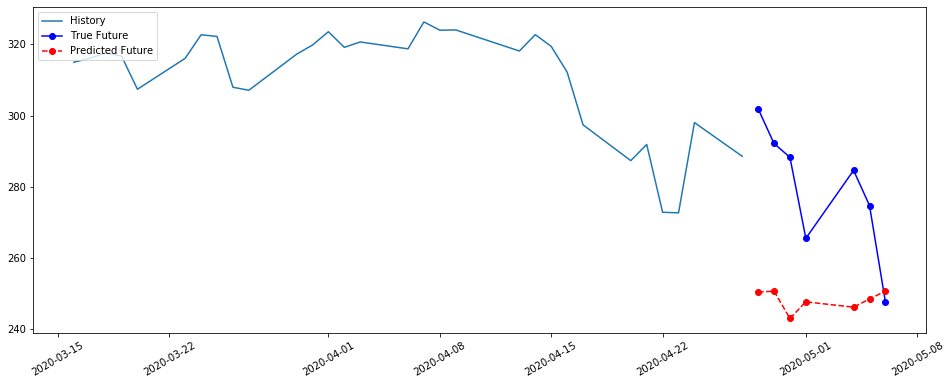

History date range: 2020-02-11 00:00:00, 2020-03-24 00:00:00
Future date range: 2020-03-25 00:00:00, 2020-04-02 00:00:00


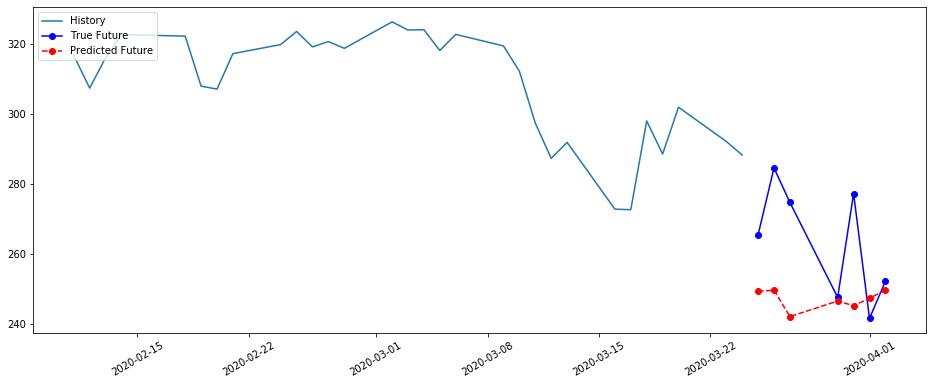

History date range: 2020-03-23 00:00:00, 2020-05-04 00:00:00
Future date range: 2020-05-05 00:00:00, 2020-05-13 00:00:00


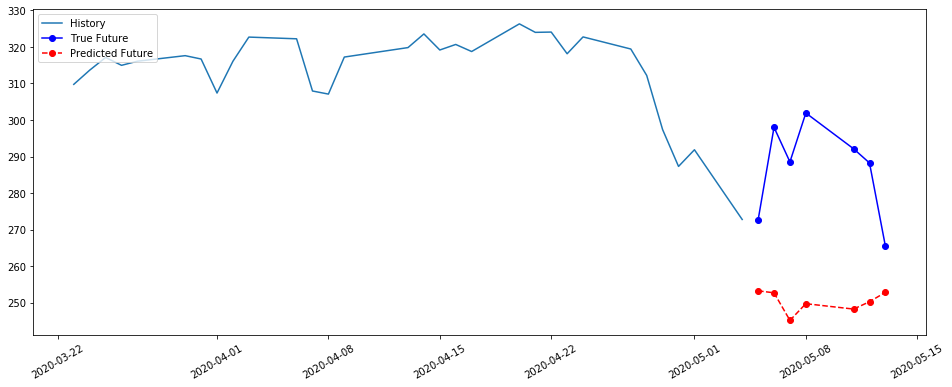

History date range: 2020-03-12 00:00:00, 2020-04-23 00:00:00
Future date range: 2020-04-24 00:00:00, 2020-05-04 00:00:00


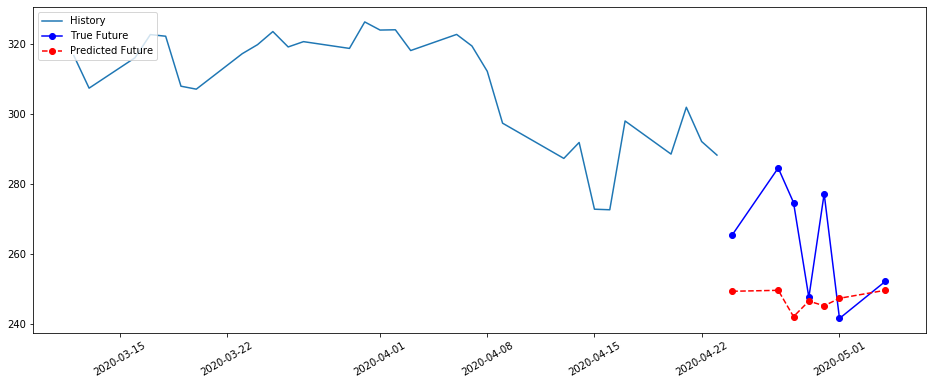

History date range: 2019-12-31 00:00:00, 2020-02-12 00:00:00
Future date range: 2020-02-13 00:00:00, 2020-02-24 00:00:00


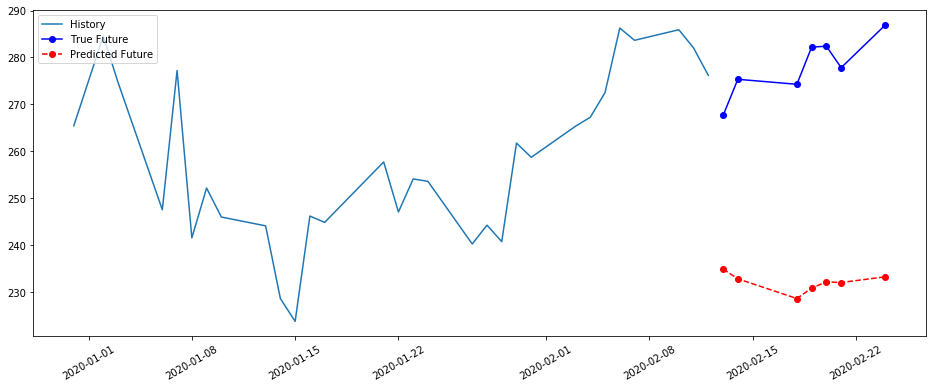

History date range: 2020-02-06 00:00:00, 2020-03-19 00:00:00
Future date range: 2020-03-20 00:00:00, 2020-03-30 00:00:00


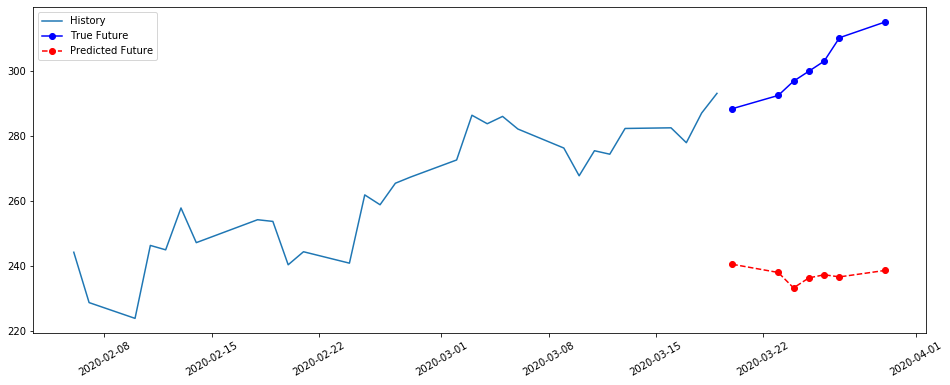

In [24]:
for xy, date in zip(test_data.take(6), test_dates.take(6)):
    
    x, y = xy
    x_dates, y_dates = date
    history = x[0].numpy()[:, target_var_index]
    history = return_original_scale(history, column_scaler['adjclose'])
    true_future = return_original_scale(y[0], column_scaler['adjclose'])
    prediction = best_model.predict(x)[0]
    prediction_rescaled = return_original_scale(prediction, column_scaler['adjclose'])
    
    multi_step_plot_dates(x_dates[0].numpy(), history,
                          y_dates[0].numpy(), true_future,
                          prediction_rescaled)